In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""读取数据并合并"""
f_s = 1.28 * 1000
sample_0 = pd.read_csv("./bear_fault/sample/0.csv")
sample_1 = pd.read_csv("./bear_fault/sample/1.csv")
sample_2 = pd.read_csv("./bear_fault/sample/2.csv")
sample_3 = pd.read_csv("./bear_fault/sample/3.csv")
sample_4 = pd.read_csv("./bear_fault/sample/4.csv")
sample = pd.concat([sample_0, sample_1, sample_2, sample_3, sample_4], axis=1)
# 数据
data_values = np.array(sample)
data_labels = np.concatenate(
    (
        np.array([0] * sample_0.shape[1]),
        np.array([1] * sample_1.shape[1]),
        np.array([2] * sample_2.shape[1]),
        np.array([3] * sample_3.shape[1]),
        np.array([4] * sample_4.shape[1]),
    )
)

In [2]:
"""滤波"""

from scipy import signal
from numpy.linalg import svd


def moving_average(data, window_size):
    # 常规方法进行平滑滤波
    smoothed_data = []
    for i in range(len(data)):
        start = max(0, i - window_size // 2)
        end = min(len(data), i + window_size // 2 + 1)
        window = data[start:end]
        smoothed_data.append(sum(window) / len(window))
    return smoothed_data


def moving_average_conv(data, window_size):
    # 卷积平滑滤波
    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, window, mode="same")
    return smoothed_data


def moving_average_sg(data, window_size, order):
    # SG滤波
    sg_data = signal.savgol_filter(data, window_size, order)
    return sg_data


def denoised_with_svd(data, nlevel=8):
    """
    :param data: 需要降噪的原始数据,1D-array
    :param nlevel: 阶次
    :return:重构后的信号
    """
    N = len(data)
    A = np.lib.stride_tricks.sliding_window_view(data, (N // 2,))
    U, S, Vh = svd(A)
    # 重构信号
    X = np.zeros_like(A)
    for i in range(nlevel):
        X += Vh[i, :] * S[i] * U[:, i : i + 1]
    X = X.T
    data_recon = np.zeros(N)
    for i in range(N):
        a = 0
        m = 0
        for j1 in range(N // 2):
            for j2 in range(N // 2 + 1):
                if i == j1 + j2:
                    a = a + X[j1, j2]  # 把矩阵重构回一维信号
                    m = m + 1
        if m != 0:
            data_recon[i] = a / m
    return data_recon

In [3]:
"""
函数定义

fft,psd,autocorr取多个峰值
"""

from scipy.fftpack import fft
from scipy.signal import welch
from scipy.signal import find_peaks_cwt


# FFT
def get_fft_values(y_values_old, f_s):
    y_values = [x for x in y_values_old if np.isnan(x) == False]
    N = len(y_values)
    f_values = np.linspace(0.0, f_s / 2.0, N // 2)
    fft_values_ = fft(y_values)
    fft_values = 2.0 / N * np.abs(fft_values_[0 : N // 2])
    return f_values, fft_values


def get_fft_n_peaks_values(data_values, f_s, window_size, order, n_peaks):
    fft_peaks_feature = np.ndarray((data_values.shape[1], n_peaks * 2))
    for i in range(data_values.shape[1]):
        f_values, fft_values = get_fft_values(data_values[:, i], f_s)
        fft_values_average = moving_average_sg(fft_values, window_size, order)
        peaks_index = find_peaks_cwt(fft_values_average, np.arange(1, 30))
        one_feature = np.append(
            f_values[peaks_index[0:n_peaks]], fft_values_average[peaks_index[0:n_peaks]]
        )
        fft_peaks_feature[i, :] = one_feature
    return fft_peaks_feature


# PSD
def get_psd_values(y_values_old, f_s):
    y_values = [x for x in y_values_old if np.isnan(x) == False]
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values


def get_psd_n_peaks_values(data_values, f_s, n_peaks):
    psd_peaks_feature = np.ndarray((data_values.shape[1], n_peaks * 2))
    for i in range(data_values.shape[1]):
        f_values, psd_values = get_psd_values(data_values[:, i], f_s)
        peaks_index = find_peaks_cwt(psd_values, np.arange(1, 10))
        one_feature = np.append(
            f_values[peaks_index[0:n_peaks]], psd_values[peaks_index[0:n_peaks]]
        )
        psd_peaks_feature[i, :] = one_feature
    return psd_peaks_feature


# Autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode="full")
    return result[len(result) // 2 :]


def get_autocorr_max_values(data_values, f_s):
    autocorr_max_feature = np.ndarray((data_values.shape[1], 2))
    for i in range(data_values.shape[1]):
        y_values_old = data_values[:, i]
        y_values = [x for x in y_values_old if np.isnan(x) == False]
        N = len(y_values)
        autocorr_values = autocorr(y_values)
        x_values = np.array([1.0 * jj / f_s for jj in range(0, N)])
        max_index = np.where(autocorr_values == np.max(autocorr_values))
        autocorr_max_feature[i, :] = np.append(
            x_values[max_index], autocorr_values[max_index]
        )
    return autocorr_max_feature


def get_time_values(data_values):
    data_values = np.nan_to_num(data_values)
    max_feature = np.max(data_values, axis=0)
    min_feature = np.min(data_values, axis=0)
    max_minus_min = max_feature - min_feature
    mean_feature = np.mean(data_values, axis=0)
    mean_square_feature = np.mean(data_values**2, axis=0)
    std_feature = np.std(data_values, axis=0)
    var_feature = np.var(data_values, axis=0)
    mean_sqrt_feature = np.sqrt(np.mean(data_values**2, axis=0))
    RMS_feature = (np.mean(np.abs(data_values), axis=0)) ** 2
    time_feature = np.array(
        [
            max_feature,
            min_feature,
            max_minus_min,
            mean_feature,
            mean_square_feature,
            std_feature,
            var_feature,
            mean_sqrt_feature,
            RMS_feature,
        ]
    )
    return time_feature.T

In [4]:
"""
提取特征

fft,psd,autocorr
最大值,最小值,峰峰值,峰值,均值,均方值,标准差,方差,RMS均方根,方根幅值
"""

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


def get_all_features(data_values, f_s, window_size, order, n_peaks=3):
    data_features_FFT = get_fft_n_peaks_values(
        data_values, f_s, window_size, order, n_peaks
    )
    data_features_PSD = get_psd_n_peaks_values(data_values, f_s, n_peaks)
    data_features_autocorr = get_autocorr_max_values(data_values, f_s)
    time_feature = get_time_values(data_values)  # 没有使用时序特征因为没用
    data_features = np.concatenate(
        (data_features_FFT, data_features_PSD, data_features_autocorr), axis=1
    )
    return data_features


data_features = get_all_features(data_values, f_s, 30, 3)

In [5]:
"""分割数据集"""

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_features,
    data_labels,
    test_size=0.4,
    shuffle=True,
    stratify=data_labels,
    random_state=1,
)
# x_train,x_test,y_train,y_test=train_test_split(data,label.ravel().astype(int))

In [6]:
"""
训练

逻辑回归,贝叶斯,KMeans,决策树,随机森林,支持向量机,xgboost,lightgbm,BP神经网络,线性判别
"""

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


LR = LogisticRegression(solver="liblinear")
LR.fit(x_train, y_train)
print(f"逻辑回归训练集得分:{LR.score(x_train,y_train)}")
print(f"逻辑回归测试集得分:{LR.score(x_test,y_test)}")

MNB = MultinomialNB()
MNB.fit(x_train, y_train)
print(f"朴素贝叶斯训练集得分:{MNB.score(x_train,y_train)}")
print(f"朴素贝叶斯测试集得分:{MNB.score(x_test,y_test)}")

BNB = BernoulliNB()
BNB.fit(x_train, y_train)
print(f"伯努利贝叶斯训练集得分:{BNB.score(x_train,y_train)}")
print(f"伯努利贝叶斯测试集得分:{BNB.score(x_test,y_test)}")

GNB = GaussianNB()
GNB.fit(x_train, y_train)
print(f"高斯贝叶斯训练集得分:{GNB.score(x_train,y_train)}")
print(f"高斯贝叶斯测试集得分:{GNB.score(x_test,y_test)}")

KNN = KNeighborsClassifier()
KNN.fit(x_train, y_train)
print(f"KNN训练集得分:{KNN.score(x_train,y_train)}")
print(f"KNN测试集得分:{KNN.score(x_test,y_test)}")

DTC = DecisionTreeClassifier()
DTC.fit(x_train, y_train)
print(f"决策树训练集得分:{DTC.score(x_train,y_train)}")
print(f"决策树测试集得分:{DTC.score(x_test,y_test)}")

RFC = RandomForestClassifier(n_estimators=1000)
RFC.fit(x_train, y_train)
print(f"随机森林训练集得分:{RFC.score(x_train,y_train)}")
print(f"随机森林测试集得分:{RFC.score(x_test,y_test)}")

SM = svm.SVC(kernel="rbf")
SM.fit(x_train, y_train)
print(f"支持向量机训练集得分:{SM.score(x_train,y_train)}")
print(f"支持向量机测试集得分:{SM.score(x_test,y_test)}")

XGB = XGBClassifier()
XGB.fit(x_train, y_train)
print(f"xgboost训练集得分:{XGB.score(x_train,y_train)}")
print(f"xgboost测试集得分:{XGB.score(x_test,y_test)}")

LGBM = LGBMClassifier(verbose=-1)
LGBM.fit(x_train, y_train)
print(f"lightgbm训练集得分:{LGBM.score(x_train,y_train)}")
print(f"lightgbm测试集得分:{LGBM.score(x_test,y_test)}")

BP = MLPClassifier(max_iter=10000, random_state=62)
BP.fit(x_train, y_train)
print(f"BP神经网络训练集得分:{BP.score(x_train,y_train)}")
print(f"BP神经网络测试集得分:{BP.score(x_test,y_test)}")

LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train, y_train)
print(f"线性判别训练集得分:{LDA.score(x_train,y_train)}")
print(f"线性判别测试集得分:{LDA.score(x_test,y_test)}")

逻辑回归训练集得分:0.8
逻辑回归测试集得分:0.8625
朴素贝叶斯训练集得分:0.6333333333333333
朴素贝叶斯测试集得分:0.6625
伯努利贝叶斯训练集得分:0.2
伯努利贝叶斯测试集得分:0.2
高斯贝叶斯训练集得分:0.8333333333333334
高斯贝叶斯测试集得分:0.9125
KNN训练集得分:0.7666666666666667
KNN测试集得分:0.575
决策树训练集得分:1.0
决策树测试集得分:0.8375
随机森林训练集得分:1.0
随机森林测试集得分:0.975
支持向量机训练集得分:0.525
支持向量机测试集得分:0.3625
xgboost训练集得分:1.0
xgboost测试集得分:0.925
lightgbm训练集得分:1.0
lightgbm测试集得分:0.975
BP神经网络训练集得分:1.0
BP神经网络测试集得分:0.7375
线性判别训练集得分:0.9583333333333334
线性判别测试集得分:0.8875


In [7]:
"""
预测

随机森林,lightgbm
"""

predict_data_values = pd.read_csv("./bear_fault/test.csv")
predict_data_values = np.array(predict_data_values)
predict_data_features = get_all_features(predict_data_values, f_s, 30, 3)

predict_data_labels_RFC = RFC.predict(predict_data_features)
predict_data_labels_LGBM = LGBM.predict(predict_data_features)
print(f"随机森林预测为{predict_data_labels_RFC}")
print(f"Lightgbm预测为{predict_data_labels_LGBM}")

随机森林预测为[2 2 0 1 4 2 2 4 2 0 2 2 2 0 2 1 0 1 0 1 2 2 0 1 4 0 3 2 0 2 0 3 4 4 2 2 2
 3 2 2 0 2 4 1 3 3 1 2 2 2 0 4 4 3 2 1 2 4 2 0 4 1 2 1 0 0 2 1 4 4 3 3 2 4
 4 2 1 0 4 2 1 1 3 1 4 2 3 3 1 4 2 4 4 1 3 0 2 3 1 0 4 0 1 0 0 2 0 4 1 0 1
 1 2 2 4 0 1 0 3 1 2 1 0 3 3 0 4 3 1 2 3 0 4 2 3 1 3 0 0 2 4 3 3 2 3 3 2 3
 2 0 4 3 2 1 4 2 1 0 3 0 3 4 4 2 4 1 4 1 2 0 3 0 0 1 1 3 0 0 2 3 0 2 3 1 4
 0 1 2 1 2 4 3 0 3 4 3 1 4 3 1 3 0 0 2 4 2 1 1 4 0 4 2 3 0 1 1 2 1 1 1 1 4
 3 1 1 1 1 3 4 2 3 1 4 1 2 4 2 0 1 2 0 1 2 2 2 2 4 3 4 0 4 2 2 2 2 4 3 2 1
 2 1 4 4 2 0 3 3 1 4 2 1 1 0 4 1 0 4 0 4 3 2 4 3 4 0 3 2 3 3 1 4 1 0 2 2 2
 2 2 4 3 4 4 4 0 2 1 0 0 4 0 3 4 0 0 2 4 1 1 3 4 0 3 4 0 1 1 1 0 1 4 4 0 4
 1 3 0 0 2 1 3 1 2 0 1 4 2 4 3 4 2 2 4 4 3 0 4 1 3 4 3 4 1 2 0 2 4 4 2 0 3
 3 2 0 4 0 0 1 2 1 2 2 3 3 3 4 2 2 3 0 4 2 3 0 0 0 4 2 1 2 3 3 2 4 0 1 0 1
 4 4 0 2 0 4 2 1 4 1 3 4 3 0 3 3 2 0 1 3 4 0 1 4 2 3 0 1 1 2 0 4 0 0 2 0 4
 2 1 0 4 3 0 3 3 1 0 3 2 4 2 3 3 0 1 1 1 4 4 1 1 0 3 0 4 4 1 3 4 4 2 3 1 1
 1 1 4 1 2 4 3 3 4

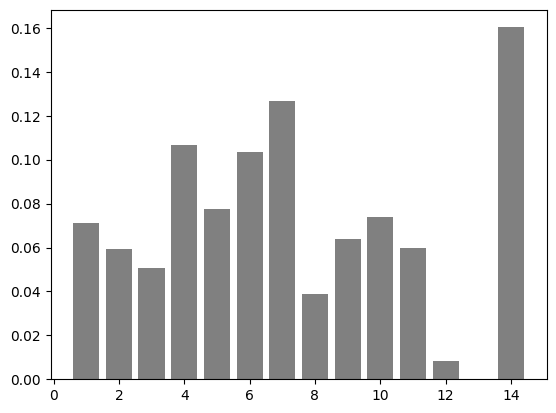

In [8]:
"""特征贡献"""
x = np.linspace(1, len(RFC.feature_importances_), len(RFC.feature_importances_))
plt.bar(x, RFC.feature_importances_, color="gray")
plt.show()

# 以下是额外技巧

## 混淆矩阵

In [ ]:
from sklearn import metrics


def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
    # 利用sklearn中的函数生成混淆矩阵并归一化
    cm = metrics.confusion_matrix(
        y_true, y_pred, labels=labels_name, sample_weight=None
    )  # 生成混淆矩阵
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # 归一化

    # 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
    plt.imshow(cm, interpolation="nearest", cmap=plt.get_cmap("Blues"))
    plt.colorbar()  # 绘制图例

    # 图像标题
    if title is not None:
        plt.title(title)
    # 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    plt.xticks(num_local, axis_labels, rotation=45)  # 将标签印在x轴坐标上， 并倾斜45度
    plt.yticks(num_local, axis_labels)  # 将标签印在y轴坐标上
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    # 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                plt.text(
                    j,
                    i,
                    format(int(cm[i][j] * 100 + 0.5), "d") + "%",
                    ha="center",
                    va="center",
                    color="white" if cm[i][j] > thresh else "black",
                )  # 如果要更改颜色风格，需要同时更改此行
    # 显示
    plt.show()

## pairplot

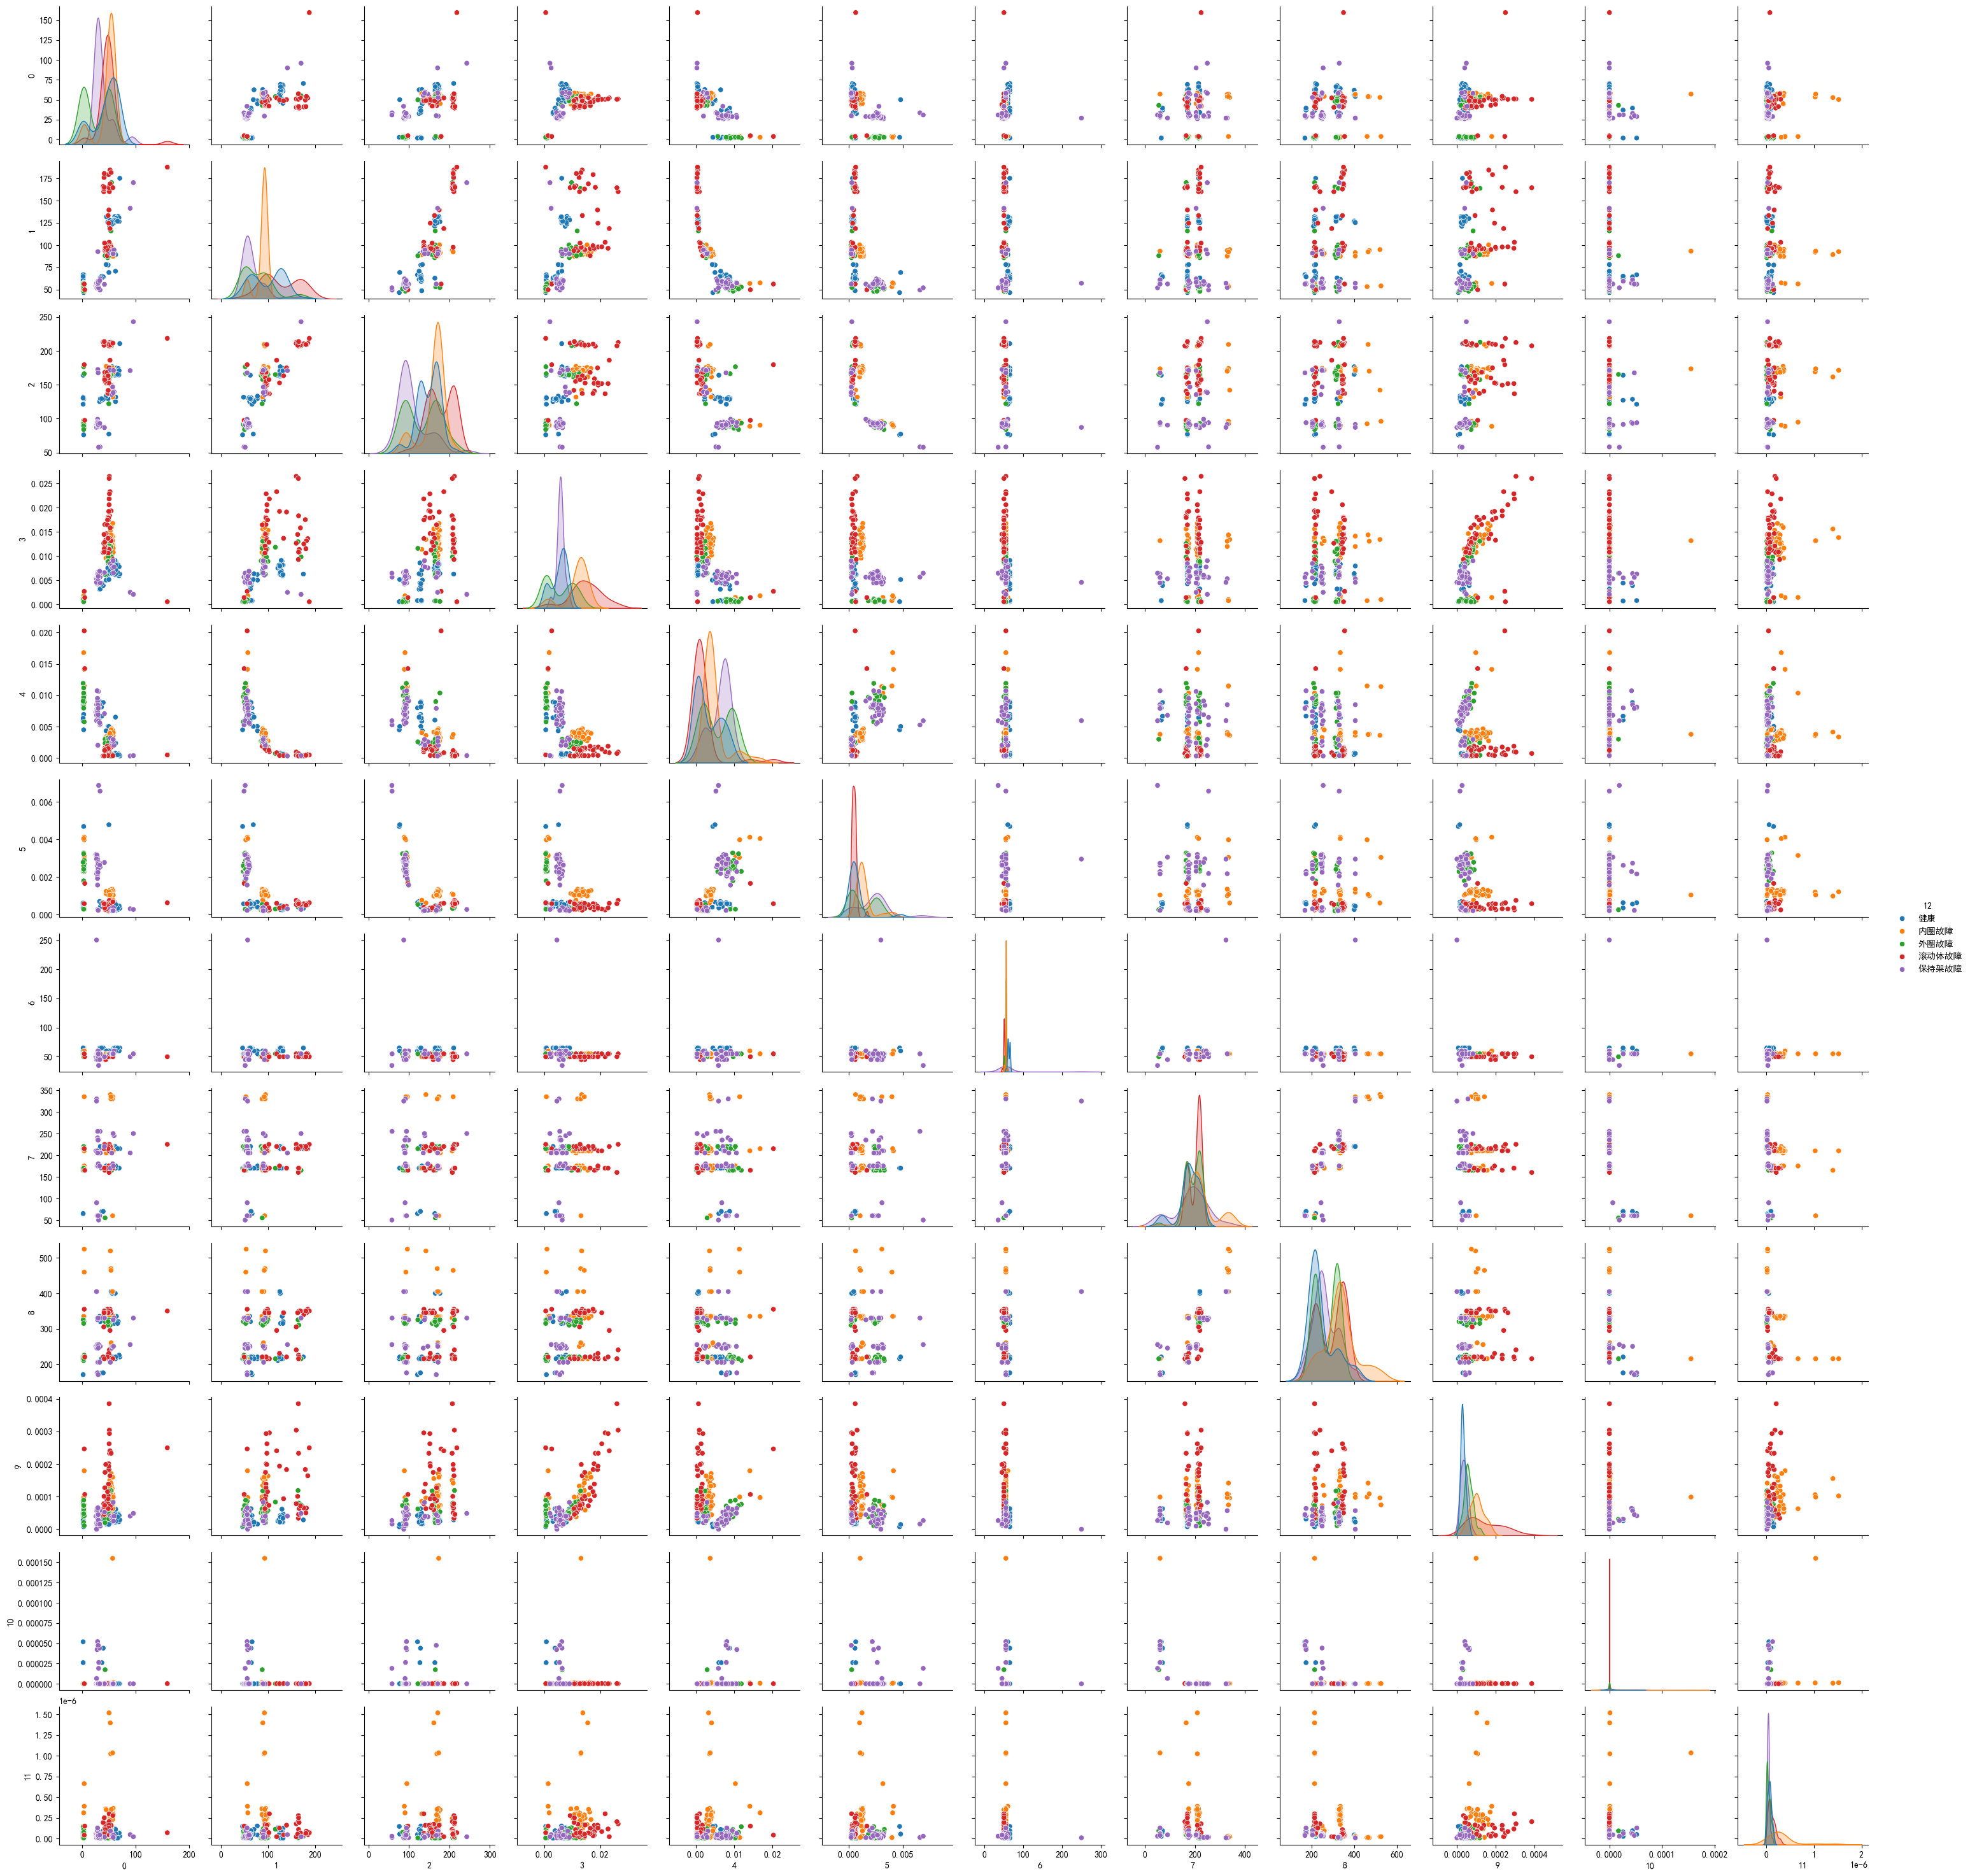

In [9]:
import seaborn as sns

plt.rcParams["font.sans-serif"] = ["SimHei"]  # 显示中文
plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号
data = np.concatenate((data_features[:, :12], data_labels.reshape(-1, 1)), axis=1)
data = pd.DataFrame(data)  # 没有设置index
data_len = data.shape[1] - 1
kind_dict = {0: "健康", 1: "内圈故障", 2: "外圈故障", 3: "滚动体故障", 4: "保持架故障"}
data[data_len] = data[data_len].map(kind_dict)
sns.pairplot(data, hue=data_len)
plt.show()

## scatter3D

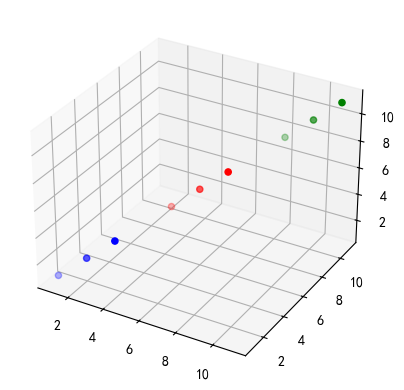

In [10]:
x = np.array([[1, 2, 3], [5, 6, 7], [9, 10, 11]])
y = np.array([[1, 2, 3], [5, 6, 7], [9, 10, 11]])
z = np.array([[1, 2, 3], [5, 6, 7], [9, 10, 11]])
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
color = ["blue", "red", "green"]
for i in range(x.shape[0]):
    ax.scatter(x[i], y[i], z[i], color=color[i])
plt.show()

## 决策树可视化

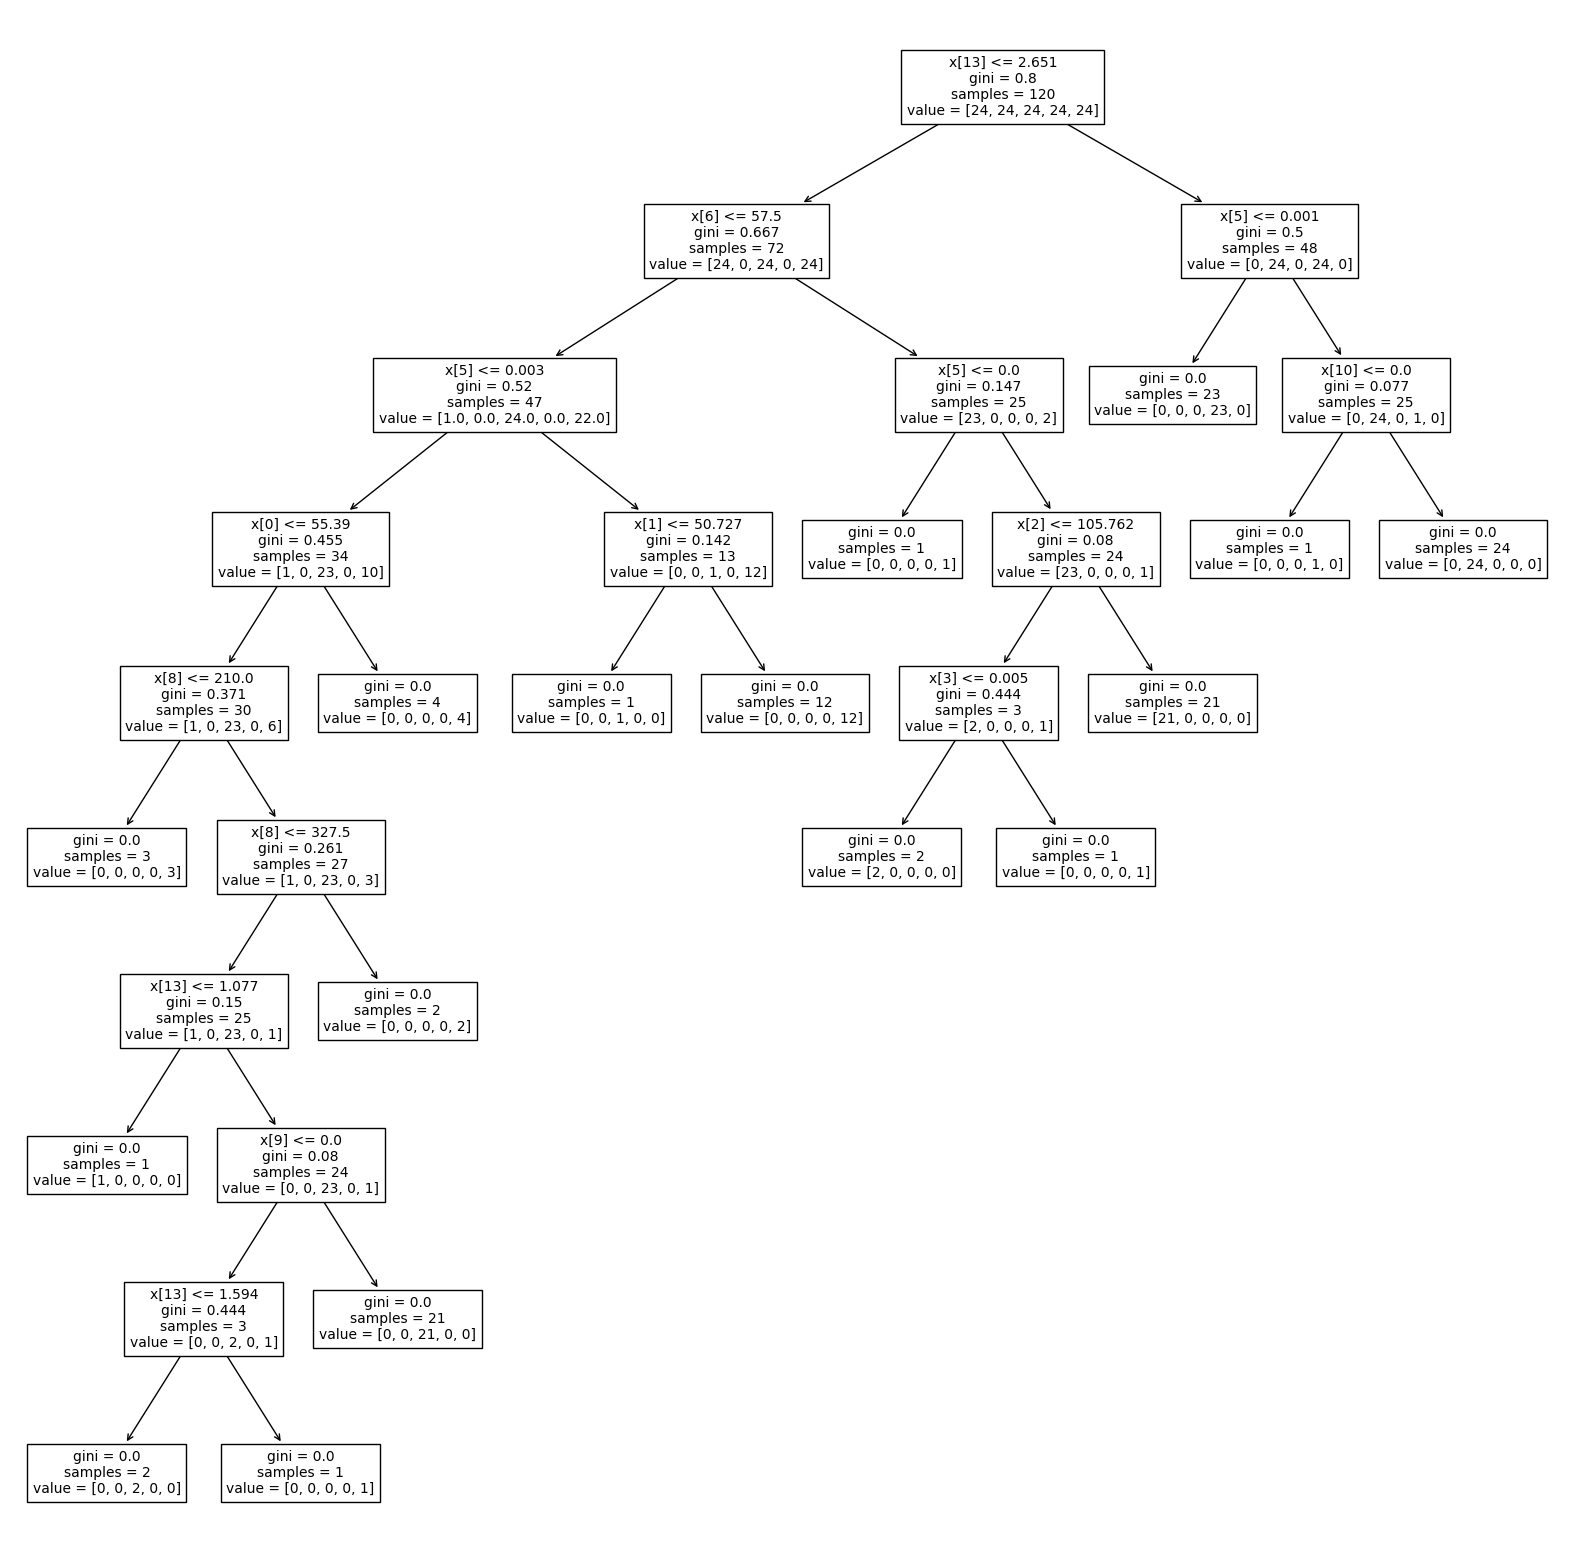

In [21]:
from sklearn.tree import plot_tree


plt.figure(figsize=(20,20))
plot_tree(DTC,fontsize=10)
plt.show()

## 插值

### 一维

In [1]:
from scipy.interpolate import interp1d
import numpy as np

xs = np.arange(10)
ys = 2 * xs + 1

interp_func = interp1d(xs, ys)

newarr = interp_func(np.arange(2.1, 3, 0.1))

print(newarr)

[5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8]


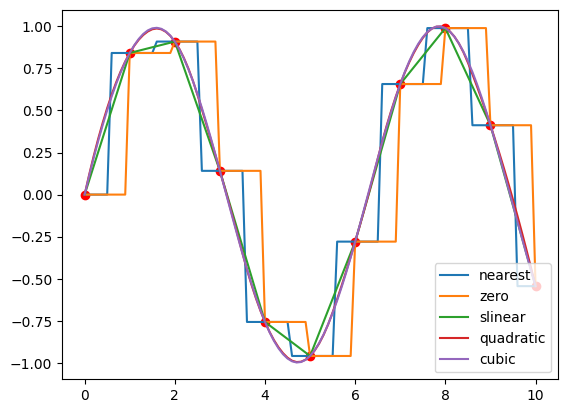

In [2]:
# -*-coding:utf-8 -*-import numpy as np
from scipy import interpolate
import pylab as pl
import numpy as np
 
x=np.linspace(0,10,11)
#x=[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
y=np.sin(x)
xnew=np.linspace(0,10,101)
pl.plot(x,y,"ro")
 
for kind in ["nearest","zero","slinear","quadratic","cubic"]:#插值方式#"nearest","zero"为阶梯插值#slinear 线性插值#"quadratic","cubic" 为2阶、3阶B样条曲线插值
    f=interpolate.interp1d(x,y,kind=kind)
    # ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first, second or third order)
    ynew=f(xnew)
    pl.plot(xnew,ynew,label=str(kind))
pl.legend(loc="lower right")
pl.show()

### 二维

C:\Users\78661\AppData\Local\Temp\ipykernel_22100\519508826.py:29: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  newfunc = interpolate.interp2d(x, y, fvals, kind='cubic')#newfunc为一个函数# 计算100*100的网格上的插值
C:\Users\78661\AppData\Local\Temp\ipykernel_22100\519508826.py:32: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regula

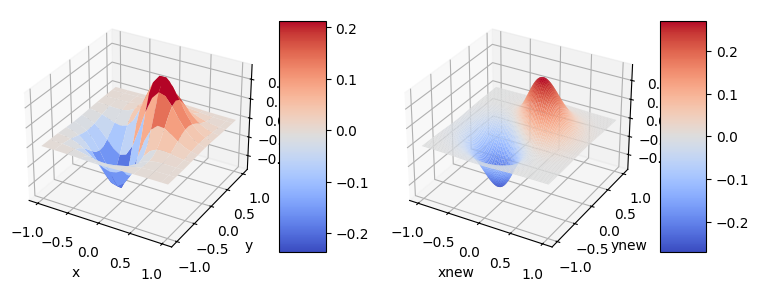

In [3]:
# -*- coding: utf-8 -*-"""
# 演示二维插值。
# -*- coding: utf-8 -*-
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy import interpolate
import matplotlib.cm as cm
import matplotlib.pyplot as plt
 
def func(x, y):
    return (x+y)*np.exp(-5.0*(x**2 + y**2))
 
# X-Y轴分为20*20的网格
x = np.linspace(-1, 1, 20)
y = np.linspace(-1,1,20)
x, y = np.meshgrid(x, y)#20*20的网格数据
 
fvals = func(x,y) # 计算每个网格点上的函数值  15*15的值
 
fig = plt.figure(figsize=(9, 6))
#Draw sub-graph1
ax=plt.subplot(1, 2, 1,projection = '3d')
surf = ax.plot_surface(x, y, fvals, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.colorbar(surf, shrink=0.5, aspect=5)#标注#二维插值
newfunc = interpolate.interp2d(x, y, fvals, kind='cubic')#newfunc为一个函数# 计算100*100的网格上的插值
xnew = np.linspace(-1,1,150)#x
ynew = np.linspace(-1,1,150)#y
fnew = newfunc(xnew, ynew)#仅仅是y值   100*100的值  np.shape(fnew) is 100*100
xnew, ynew = np.meshgrid(xnew, ynew)
ax2=plt.subplot(1, 2, 2,projection = '3d')
surf2 = ax2.plot_surface(xnew, ynew, fnew, rstride=2, cstride=2, cmap=cm.coolwarm,linewidth=0.5, antialiased=True)
ax2.set_xlabel('xnew')
ax2.set_ylabel('ynew')
ax2.set_zlabel('fnew(x, y)')
plt.colorbar(surf2, shrink=0.5, aspect=5) #标注
 
plt.show()